# EDA for Big Data Derby Competition

### Creating paths to diferent folders

In [1]:
import os
from pathlib import Path

# Get current work directory of file (Notebook dir)
NOTEBOOK_DIR=Path(os.path.abspath(os.getcwd()))
# Root path of repo
WORK_DIR=NOTEBOOK_DIR.parent.parent
# Path to Datasets
DATA_DIR=WORK_DIR / 'data'

# Noob printing to check if I did this shit right
print("Notebook dir: ", NOTEBOOK_DIR)
print("Repo dir: ", WORK_DIR)
print("Data dir: ", DATA_DIR)

Notebook dir:  r:\kaggle\big-data-derby-kaggle\notebooks\sainth
Repo dir:  r:\kaggle\big-data-derby-kaggle
Data dir:  r:\kaggle\big-data-derby-kaggle\data


### Loading csv into dataframes

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])
complete_data['race_date'].value_counts()
mix_cd = complete_data.set_index(['track_id', 'race_date', 'race_number', 'program_number'])


C:\Users\santi\AppData\Local\Temp\ipykernel_27768\36363920.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data= pd.read_csv(DATA_DIR / 'nyra_2019_complete.csv', names=['track_id','race_date','race_number','program_number','trakus_index','latitude','longitude','distance_id','course_type','track_condition','run_up_distance','race_type','purse','post_time','weight_carried','jockey','odds','position_at_finish'])


In [3]:
race_result_df = complete_data.groupby(['track_id', 'race_date','race_number','jockey'])['race_type', 'track_condition','program_number','weight_carried','position_at_finish'].first()
rcd=race_result_df.reset_index()
rcd.head()

C:\Users\santi\AppData\Local\Temp\ipykernel_27768\2552478482.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  race_result_df = complete_data.groupby(['track_id', 'race_date','race_number','jockey'])['race_type', 'track_condition','program_number','weight_carried','position_at_finish'].first()


,track_id,race_date,race_number,jockey,race_type,track_condition,program_number,weight_carried,position_at_finish
0,AQU,2019-01-01,1,Dylan Davis,AOC,MY,1,123,2
1,AQU,2019-01-01,1,Jomar Garcia,AOC,MY,4,123,5
2,AQU,2019-01-01,1,Jose Lezcano,AOC,MY,3,118,4
3,AQU,2019-01-01,1,Junior Alvarado,AOC,MY,2,120,3
4,AQU,2019-01-01,1,Manuel Franco,AOC,MY,5,118,1


## Load Race table df, and check race location distribution


<AxesSubplot:>

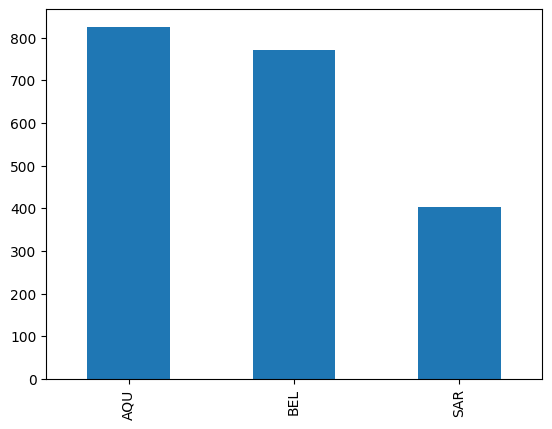

In [8]:
race_data = pd.read_csv(DATA_DIR / 'nyra_race_table.csv')

race_data['track_id'].value_counts().plot(kind='bar')

<AxesSubplot:>

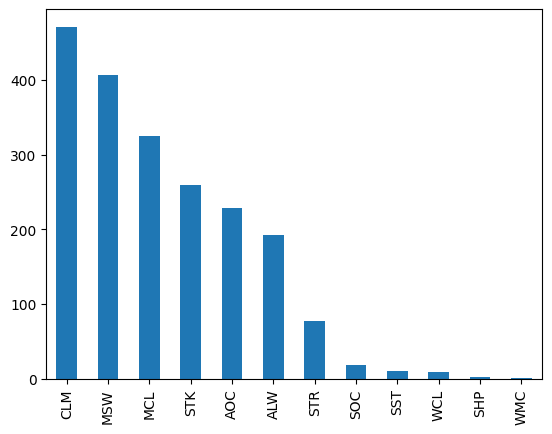

In [120]:
race_data['race_type'].value_counts().plot(kind='bar')

## Managing data about races... Distance, Velocity and Acceleration

### For now, let's check good jockeys for evaluation, i.e. Who are the best and the worst "W/L" in more races

In [9]:
# Let's check which is the best "winner jockey" to evaluate 
rcd[rcd['position_at_finish']==1].jockey.describe()

count              2003
unique               67
top       Manuel Franco
freq                214
Name: jockey, dtype: object

In [10]:
# Now let's check the same for best "looser jockey" case.
# Since we don't have always the same amount of competitors,
# let's check which is the most common quantity of positions

rcd[rcd['position_at_finish']==6].jockey.describe()


count            1692
unique             94
top       Dylan Davis
freq              147
Name: jockey, dtype: object

### Now that we know that 'Manuel Franco' and 'Dylan Davis' are respectively the "most 1st" and "most sixth", lets try to add distance, velocity and acceleration

#### Considerations: Trackus index starts at 1.

In [11]:
from math import radians, cos, sin, asin, sqrt, ceil

# Let's def function to apply Haversine formulae
# this snippet of code is extracted from https://www.geeksforgeeks.org/program-distance-two-points-earth/
# by Aarti_Rathi
def haversine_distance(row):
    # Convert from degrees to radians.
    lon1 = radians(row.longitude)
    lon2 = radians(row.shift_longitude)
    lat1 = radians(row.latitude)
    lat2 = radians(row.shift_latitude)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)


So, we now (at least i think) have the distance the horse have runned. now let's check how many readings were made by trakus for the run-up (58 feet in this example).
We may want to replace iterrows with cumsum

#### Now let's get some more interesting stats, like velocity and acceleration!

In [12]:
def velocity(row):
    km_to_m=row.trakus_distance*1000
    time=0.25
    v_m_s = km_to_m / time
    return v_m_s

def acceleration(row):
    delta_v = row.velocity - row.shift_velocity
    time = 0.25
    a_m_s2= delta_v / time
    return a_m_s2


### Let's find slower competitor

In [13]:
complete_data[(complete_data.track_id == "AQU")
& (complete_data.race_date == "2019-04-19")
& (complete_data.race_number == 7)
& (complete_data.position_at_finish == 6)
].jockey

1357303    Hector Rafael Diaz Jr.
1357304    Hector Rafael Diaz Jr.
1357305    Hector Rafael Diaz Jr.
1357306    Hector Rafael Diaz Jr.
1357307    Hector Rafael Diaz Jr.
                    ...          
1357573    Hector Rafael Diaz Jr.
1357574    Hector Rafael Diaz Jr.
1357575    Hector Rafael Diaz Jr.
1357576    Hector Rafael Diaz Jr.
1357577    Hector Rafael Diaz Jr.
Name: jockey, Length: 275, dtype: object

Now, to apply same result than previous guy, maybe do a function to make this isolated dataframes

In [14]:
def isolate_jockey_and_race(complete_data_df, jockey, track_id, race_date, race_number):
    
    # Reading race data into df
    single_jockey_race=complete_data_df[(complete_data_df.jockey == jockey)
    & (complete_data_df.track_id == track_id)
    & (complete_data_df.race_date == race_date)
    & (complete_data_df.race_number == race_number)
    ]
    
    # Adding "previuos coordinates" to data frame with pandas shift func
    single_jockey_race=single_jockey_race.sort_values(by='trakus_index')
    r_shift = single_jockey_race.shift()
    r_shift
    single_jockey_race['shift_latitude']=r_shift['latitude'].fillna(0)
    single_jockey_race['shift_longitude']=r_shift['longitude'].fillna(0)

    # Add distance between current trakus read and previous one
    single_jockey_race['trakus_distance']=single_jockey_race.apply(haversine_distance, axis='columns')
    single_jockey_race['trakus_distance']=single_jockey_race.trakus_distance.map(lambda td: 0 if td>1 else td)
    single_jockey_race['distance_covered']=single_jockey_race.trakus_distance.cumsum()

    # Add Velocity and acceleration
    single_jockey_race['velocity']=single_jockey_race.apply(velocity, axis='columns')
    single_jockey_race_vshift=single_jockey_race.shift()
    single_jockey_race['shift_velocity']=single_jockey_race_vshift['velocity'].fillna(0)
    single_jockey_race['acceleration']=single_jockey_race.apply(acceleration, axis='columns')

    # Print some stats
    runup_kmd=0.0176784   
    rand_d=0 # runup distance
    tix=0 # trackus index post ranup distance
    for index, row in single_jockey_race.iterrows():
        rand_d=rand_d+row.trakus_distance
        if rand_d > runup_kmd:
            ntix=row.trakus_index
            tix = row.trakus_index - 1
            break
    total_distance = single_jockey_race.trakus_distance.sum() * 1000 
    runup_distance = rand_d * 1000
    race_distance = (single_jockey_race.distance_id.unique()[0] / 100) * 201.168 # from furlongs to meters
    excess_distance = total_distance - runup_distance - race_distance

    print(f'''Race of {jockey}, in {track_id}, {race_date}, race number: {race_number}
    Total distance ran: {total_distance} m
    runup distance: {runup_distance} m
    declared race distance: {race_distance} m
    excess distance: {excess_distance} m
    ''')

    return single_jockey_race

    

In [16]:
# results for Hector Rafael Diaz Jr.
hector_rdj_df=isolate_jockey_and_race(complete_data_df=complete_data, jockey="Hector Rafael Diaz Jr.", track_id="AQU", race_date="2019-04-19", race_number=7)


Race of Hector Rafael Diaz Jr., in AQU, 2019-04-19, race number: 7
    Total distance ran: 1335.1686100972129 m
    runup distance: 19.730840368024698 m
    declared race distance: 1207.008 m
    excess distance: 108.42976972918814 m
    


In [17]:
manuel_f_df=isolate_jockey_and_race(complete_data_df=complete_data, jockey="Manuel Franco", track_id="AQU", race_date="2019-04-19", race_number=7)


Race of Manuel Franco, in AQU, 2019-04-19, race number: 7
    Total distance ran: 1346.3377664612817 m
    runup distance: 17.9566026930563 m
    declared race distance: 1207.008 m
    excess distance: 121.37316376822537 m
    


#### Let's do some visualization!

In [18]:
manuel_f_df.acceleration.describe()

count    275.000000
mean       0.225184
std        1.619884
min       -3.060138
25%       -0.791694
50%        0.115944
75%        0.874312
max       10.016104
Name: acceleration, dtype: float64

In [19]:
hector_rdj_df.acceleration.describe()

count    275.000000
mean       0.227366
std        1.639196
min       -4.100741
25%       -0.693390
50%        0.048179
75%        0.856744
max       11.615158
Name: acceleration, dtype: float64

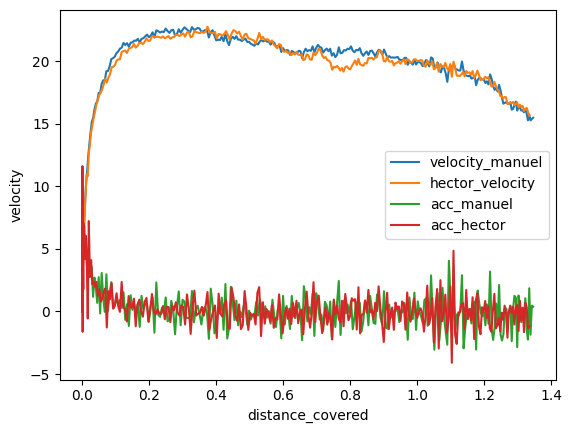

In [20]:

sns.lineplot(x="distance_covered", y="velocity",
data=manuel_f_df, label="velocity_manuel")
sns.lineplot(x="distance_covered", y="velocity", label="hector_velocity",
data=hector_rdj_df)
sns.lineplot(x="distance_covered", y="acceleration", label="acc_manuel",
data=manuel_f_df)
sns.lineplot(x="distance_covered", y="acceleration", label="acc_hector",
data=hector_rdj_df)
plt.legend()

In [118]:
manuel_f_df



,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,...,jockey,odds,position_at_finish,shift_latitude,shift_longitude,trakus_distance,distance_covered,velocity,shift_velocity,acceleration
297,AQU,2019-04-19,7,2,1,40.669548,-73.829641,600,O,FM,...,Manuel Franco,335,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
298,AQU,2019-04-19,7,2,2,40.669553,-73.829638,600,O,FM,...,Manuel Franco,335,2,40.669548,-73.829641,0.000626,0.000626,2.504026,0.000000,10.016104
299,AQU,2019-04-19,7,2,3,40.669559,-73.829635,600,O,FM,...,Manuel Franco,335,2,40.669553,-73.829638,0.000683,0.001309,2.731228,2.504026,0.908808
300,AQU,2019-04-19,7,2,4,40.669567,-73.829632,600,O,FM,...,Manuel Franco,335,2,40.669559,-73.829635,0.000968,0.002276,3.870441,2.731228,4.556852
301,AQU,2019-04-19,7,2,5,40.669578,-73.829627,600,O,FM,...,Manuel Franco,335,2,40.669567,-73.829632,0.001237,0.003513,4.947897,3.870441,4.309826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,AQU,2019-04-19,7,2,271,40.670832,-73.831894,600,O,FM,...,Manuel Franco,335,2,40.670864,-73.831880,0.003817,1.330871,15.268296,15.828894,-2.242391
304,AQU,2019-04-19,7,2,272,40.670798,-73.831909,600,O,FM,...,Manuel Franco,335,2,40.670832,-73.831894,0.003933,1.334804,15.732723,15.268296,1.857709
305,AQU,2019-04-19,7,2,273,40.670766,-73.831923,600,O,FM,...,Manuel Franco,335,2,40.670798,-73.831909,0.003817,1.338621,15.268090,15.732723,-1.858533
306,AQU,2019-04-19,7,2,274,40.670733,-73.831938,600,O,FM,...,Manuel Franco,335,2,40.670766,-73.831923,0.003846,1.342467,15.384420,15.268090,0.465319


In [110]:
manuel_f_df.track_id.unique()[0]

'AQU'

In [82]:
import math

furlong_race_distance = manuel_f_df.distance_id.max() / 100
meters_race_distance = furlong_race_distance * 201.168
km_runup = manuel_f_df.run_up_distance.max() * 0.0003048
tix=manuel_f_df[manuel_f_df.distance_covered<=km_runup].trakus_index.max() + 1
trakus_index_step= math.ceil((manuel_f_df.trakus_index.max() - tix) / 5)
trakus_index_step



53

In [119]:
import numpy as np
tuple_start = 1
index_interval=[]
for i in range(0,6):
    tuple_end= tix + (trakus_index_step * i)
    index_interval.append((tuple_start, tuple_end))
    tuple_start=tuple_end + 1
    

bins=pd.IntervalIndex.from_tuples(index_interval)
manuel_f_df_grouped = manuel_f_df.groupby(pd.cut(manuel_f_df["trakus_index"], bins))

jockey_performance_data={
    'AQU': 1 if manuel_f_df.track_id.unique() == 'AQU' else 0,
    'BEL': 1 if manuel_f_df.track_id.unique() == 'BEL' else 0,
    'CLM': 1 if manuel_f_df.race_type.unique() == 'CLM' else 0,
    'MSW': 1 if manuel_f_df.race_type.unique() == 'MSW' else 0,
    'MCL': 1 if manuel_f_df.race_type.unique() == 'MCL' else 0,
    'STK': 1 if manuel_f_df.race_type.unique() == 'STK' else 0,
    'trakus_index_qunatity': manuel_f_df.trakus_index.max(),
    'race_distance': manuel_f_df.distance_id.max(),
    'track_condition': 1 if manuel_f_df.track_condition.unique() in ['GD', 'FT', 'FM'] else 0,
    'run_up_distance': manuel_f_df_grouped.trakus_distance.sum().iloc[0],
    'average_speed_run_up':manuel_f_df_grouped.velocity.mean().iloc[0],
    'average_acceleration_run_up':manuel_f_df_grouped.acceleration.mean().iloc[0],
    'weight_carried':manuel_f_df.weight_carried.unique(),
    'jockey': manuel_f_df.jockey.unique(), 
    'odds':manuel_f_df.odds.unique(),
    'distance_segement_1':manuel_f_df_grouped.trakus_distance.sum().iloc[1],
    'average_speed_segement_1':manuel_f_df_grouped.velocity.mean().iloc[1],
    'average_acceleration_segement_1':manuel_f_df_grouped.acceleration.mean().iloc[1],
    'distance_segement_2':manuel_f_df_grouped.trakus_distance.sum().iloc[2],
    'average_speed_segement_2':manuel_f_df_grouped.velocity.mean().iloc[2],
    'average_acceleration_segement_2':manuel_f_df_grouped.acceleration.mean().iloc[2],
    'distance_segement_3':manuel_f_df_grouped.trakus_distance.sum().iloc[3],
    'average_speed_segement_3':manuel_f_df_grouped.velocity.mean().iloc[3],
    'average_acceleration_segement_3':manuel_f_df_grouped.acceleration.mean().iloc[3],
    'distance_segement_4':manuel_f_df_grouped.trakus_distance.sum().iloc[4],
    'average_speed_segement_4':manuel_f_df_grouped.velocity.mean().iloc[4],
    'average_acceleration_segement_4':manuel_f_df_grouped.acceleration.mean().iloc[4],
    'distance_segement_5':manuel_f_df_grouped.trakus_distance.sum().iloc[5],
    'average_speed_segement_5':manuel_f_df_grouped.velocity.mean().iloc[5],
    'average_acceleration_segement_5':manuel_f_df_grouped.acceleration.mean().iloc[5], 
    'position_at_finish':manuel_f_df.position_at_finish.unique()
}

manuel_performance=pd.DataFrame(jockey_performance_data)
manuel_performance




,AQU,BEL,CLM,MSW,MCL,STK,trakus_index_qunatity,race_distance,track_condition,run_up_distance,...,distance_segement_3,average_speed_segement_3,average_acceleration_segement_3,distance_segement_4,average_speed_segement_4,average_acceleration_segement_4,distance_segement_5,average_speed_segement_5,average_acceleration_segement_5,position_at_finish
0,1,0,1,0,0,0,275,600,0,0.017957,...,0.2706,20.815387,-0.054068,0.259593,19.968724,-0.113301,0.22217,17.425091,-0.295844,2
